In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

from lib.FramesDataset import FramesDataset
from lib import network

WARMUP = 20
T_STEPS = 5
FRAME_SIZE = 20

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

Using cuda


In [2]:
train_dataset = FramesDataset('./datasets/processed_dataset_small.pkl', 'train', WARMUP)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)

print("Training dataset length:", len(train_dataset))

Training dataset length: 135000


In [3]:
model = network.RNN(hidden_units = 400, frame_size = FRAME_SIZE, t_steps = T_STEPS)
model = model.to(DEVICE)

n_epochs = 2
lr=3e-4

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, n_epochs + 1):
    for batch_n, data in enumerate(train_data_loader):
        inputs, targets = data
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
        optimizer.zero_grad()
        output = model(inputs)
        loss = network.L1_regularisation(10e-6, criterion(output, targets), model)
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)  #Gradient Value Clipping
        optimizer.step()

    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Loss: {:.4f}".format(loss.item()))
    
model.save()

Epoch: 1/2............. Loss: 0.9523
Epoch: 2/2............. Loss: 0.8580
Saved model as ./model-20210206-133823.pt


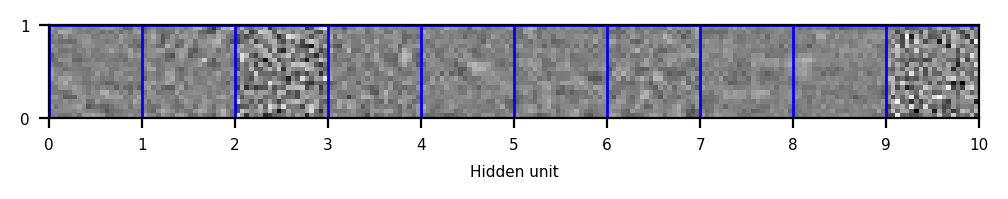

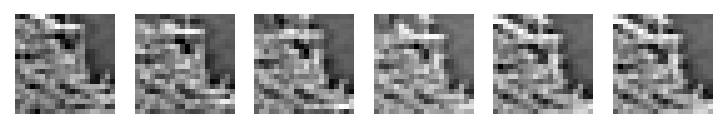

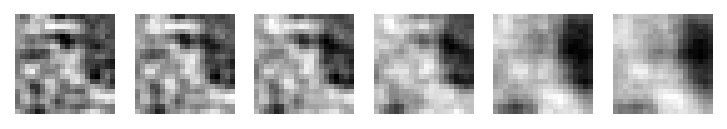

In [7]:
model = network.RNN.load(
    hidden_units = 400,
    frame_size = FRAME_SIZE,
    t_steps = T_STEPS,
    path = './models/model-2000epochs-20210206-080756.pt'
)

network.plot_input_weights(model, hidden_units = 10, frame_size = FRAME_SIZE)

x, y = train_dataset[0]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred = torch.squeeze(model(torch.unsqueeze(x, 0)), 0)

fig, axes = plt.subplots(1, T_STEPS+1, dpi=150)
for i in range(T_STEPS+1):
    im_y = y[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, T_STEPS+1, dpi=150)
for i in range(T_STEPS+1):
    im_pred = pred[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
plt.show()